In [1]:
import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu0")

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 780 (CNMeM is disabled)


In [2]:
import skimage
skimage.__version__ # We need at least version 0.11.3

'0.11.3'

In [3]:
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline

In [4]:
start = time.time()
npzfile = np.load('HCS_72x72.npz')
print ("Loaded data in " + str(time.time() - start))

Loaded data in 0.000756025314331


In [5]:
npzfile.files

['arr_1', 'arr_0', 'arr_2']

In [22]:
start = time.time()
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
Y = np.asarray(Y,dtype='int32')
cell_rows = np.asarray(cell_rows,dtype='int32')
print ("Loaded data in " + str(time.time() - start))

Loaded data in 10.1283891201


In [23]:
np.shape(cell_rows), np.shape(Y), np.shape(X), type(X)

((52950,), (52950,), (52950, 5, 72, 72), numpy.ndarray)

### Normalization

In [24]:
Xmean = X.mean(axis = 0)
XStd = np.sqrt(X.var(axis=0))
X = (X-Xmean)/(XStd + 0.01)

In [25]:
np.min(X), np.max(X), np.mean(X) #(-2.5272908, 58.301613, -3.3162789e-07)

(-2.5272908, 58.301613, -3.3162789e-07)

## Splitting into training and test set


#### Version 1
We take all, which is  below 40000 for training and validation and images above for testing.

In [26]:
# Currently a Acc. of 0.8250
if False:
    split = 40000
    X_train = X[0:split,:,:,:]
    Y_train = Y[0:split]
    X_test = X[split:,:,:,:]
    Y_test = Y[split:]

#### Version 2
80%, 20% randomly choosen. Used in the Poster (and prob. in paper)

In [27]:
# Currently a Acc. of 0.8976
if False: 
    np.random.seed(seed=42)
    perm1 = np.random.permutation(len(Y))
    print('Sum of permutation {0}'.format(np.sum(perm1))) #1401824775
    N_split = int(len(Y) * 0.8)
    N_split
    idx_train  = perm1[:N_split]
    idx_test  = perm1[N_split:]


    X_train = X[idx_train,:,:,:]
    Y_train = Y[idx_train]
    X_test = X[idx_test,:,:,:]
    Y_test = Y[idx_test]

#### Version 3
Separating a complete well from the training set and use this for testing

In [28]:
if False:
    idx_test = np.asarray(np.recfromtxt ('test_set_data.csv'))
    idx_test
    X_train = X[idx_test== False]
    X_test = X[idx_test]
    Y_train = Y[idx_test== False]
    Y_test = Y[idx_test]
    X_test.shape, Y_test.shape, X_train.shape, Y_train.shape

#### Version 3 (With modifications suggested by the reviewer)
As suggested by the reviewer

In [29]:
if False:
    idx_test = np.asarray(np.recfromtxt ('test_set_data_without_one_compound.csv'))
    idx_train = (idx_test == False)
    X_train = X[idx_test== False]
    X_test = X[idx_test]
    Y_train = Y[idx_test== False]
    Y_test = Y[idx_test]
    X_test.shape, Y_test.shape, X_train.shape, Y_train.shape

#### Version 4 (No DMSO and seperate well)

In [30]:
if True:
    Y = Y -1
    idx_DMSO = np.asarray(np.recfromtxt ('DMSO_data.csv'))
    print('Number of DMSO {}'.format(np.sum(idx_DMSO)))

    #idx_test_all = np.asarray(np.recfromtxt ('test_set_data.csv'))
    idx_test_all = np.asarray(np.recfromtxt ('test_set_data_without_one_compound.csv')) #<-- Reviewer

    idx_test  = idx_test_all & (idx_DMSO == False)
    idx_train = (idx_test_all == False) & (idx_DMSO == False)
    

    X_train = X[idx_train]
    Y_train = Y[idx_train]

    X_test = X[idx_test]
    Y_test = Y[idx_test]


    X_test.shape, Y_test.shape, X_train.shape, Y_train.shape #1964 and 10203

Number of DMSO 40783


In [31]:
X_test.shape, Y_test.shape, X_train.shape, Y_train.shape

((2223, 5, 72, 72), (2223,), (9944, 5, 72, 72), (9944,))

In [32]:
idx_test.shape, idx_train.shape, idx_DMSO.shape
np.sum(idx_test) + np.sum(idx_train) + np.sum(idx_DMSO)

52950

In [33]:
np.sum(idx_test & idx_train)

0

#### Testing of the seperation

In [34]:
import pandas as pd
cells_all = pd.read_csv('/home/dueo/data/Genedata/Cells.csv')
cells = cells_all.iloc[cell_rows]

In [35]:
np.histogram(cells['Metadata_Phenotype'][idx_train],bins=[0, 1, 2, 3, 4])

(array([   0, 1541, 8057,  346]), array([0, 1, 2, 3, 4]))

In [36]:
np.histogram(cells['Metadata_Phenotype'][idx_test],bins=[0, 1, 2, 3, 4])

(array([   0,  447, 1708,   68]), array([0, 1, 2, 3, 4]))

#### Permuting the training set
The training set has to be permuted, otherwise we have too similar compounds in the training set.

In [37]:
perm = np.random.permutation(len(Y_train))
XX = X_train[perm]
YY = Y_train[perm]
YY = np.asarray(YY,dtype='int32')
NUM_OUTPUT = int(np.max(YY)) + 1

In [38]:
YY.shape, XX.shape, np.max(YY), NUM_OUTPUT

((9944,), (9944, 5, 72, 72), 2, 3)

In [39]:
np.histogram(Y,bins=[0, 1, 2, 3, 4]),NUM_OUTPUT

((array([1988, 9765,  414,    0]), array([0, 1, 2, 3, 4])), 3)

## Architekture of the network
This Network is inspired by the oxford net VGGNet, see e.g. http://cs231n.github.io/convolutional-networks/#case

* Convolution with 3x3 layers (stride = 1 and pad = 1)
* Pooling 2x2 (stride = 2 no padding)

In [40]:
PIXELS = 72

from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

conv = (3,3)
stride = (1,1)
pool = (2,2)

num1 = 32
num2 = 64
num3 = 128
num4 = 256
num5 = 256

net_bigger = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        
        ('conv1', layers.Conv2DLayer),
        ('conv11', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        
        ('conv2', layers.Conv2DLayer),
        ('conv22', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        
        ('conv3', layers.Conv2DLayer),
        ('conv33', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        
#         ('conv4', layers.Conv2DLayer),
#         ('conv44', layers.Conv2DLayer),
#         ('pool4', layers.MaxPool2DLayer),
        
#         ('conv5', layers.Conv2DLayer),
#         ('conv55', layers.Conv2DLayer),
#         ('pool5', layers.MaxPool2DLayer),
                
              
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        
        ('hidden2', layers.DenseLayer),
        ('dropout2', layers.DropoutLayer),
        
        ('hidden3', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 5, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    
    conv1_num_filters=num1, conv1_filter_size=conv, conv1_stride=stride, 
    conv11_num_filters=num1, conv11_filter_size=conv, conv11_stride=stride,
    pool1_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    conv2_num_filters=num2, conv2_filter_size=conv, conv2_stride=stride, 
    conv22_num_filters=num2, conv22_filter_size=conv, conv22_stride=stride,
    pool2_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    conv3_num_filters=num3, conv3_filter_size=conv, conv3_stride=stride, 
    conv33_num_filters=num3, conv33_filter_size=conv, conv33_stride=stride,
    pool3_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
#     conv4_num_filters=num4, conv4_filter_size=conv, conv4_stride=stride, 
#     conv44_num_filters=num4, conv44_filter_size=conv, conv44_stride=stride,
#     pool4_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
#     conv5_num_filters=num5, conv5_filter_size=conv, conv5_stride=stride, 
#     conv55_num_filters=num5, conv55_filter_size=conv, conv55_stride=stride,
#     pool5_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    hidden1_num_units=200,
    dropout1_p=0.3,
    
    hidden2_num_units=200,
    dropout2_p=0.3,
    
    hidden3_num_units=50,
    dropout3_p=0.3,
    
    output_num_units=NUM_OUTPUT, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=20,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

We see a overfitting after approx 20 Epochs.

# Using data augmentation
Rotations are a bit tricky in skimage ...

before -0.707928299904 after -0.251041829586
before -0.586495280266 after -0.175875365734
before -0.557862579823 after -0.144647181034
before -0.372540026903 after -0.181155592203


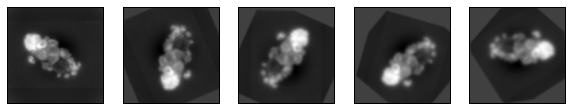

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
from skimage import transform as tf

#rots = np.deg2rad(np.asarray((90,180,0,5,-5,10,-10)))
rots = np.deg2rad(range(0,359))

dists = (-5,5)

def manipulateTrainingData(Xb):
    retX = np.zeros((Xb.shape[0], Xb.shape[1], Xb.shape[2], Xb.shape[3]), dtype='float32')
    for i in range(len(Xb)):
        rot = rots[np.random.randint(0, len(rots))]

        tf_rotate = tf.SimilarityTransform(rotation=rot)
        shift_y, shift_x = np.array((X.shape[2], X.shape[3])) / 2.
        tf_shift = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        tf_shift_inv = tf.SimilarityTransform(translation=[shift_x, shift_y])
        tform_rot = (tf_shift + (tf_rotate + tf_shift_inv))

        ## TODO add the transformations
        scale = np.random.uniform(0.9,1.10)
        d = tf.SimilarityTransform(scale=scale, translation=(np.random.randint(5),np.random.randint(5)))
        tform_other = (tform_rot + d)

        for c in range(np.shape(X)[1]):
            maxAbs = 256.0;np.max(np.abs(Xb[i,c,:,:]))
            # Needs at lease 0.11.3
            retX[i,c,:,:] = tf.warp(Xb[i,c,:,:], tform_other, preserve_range = True) # "Float Images" are only allowed to have values between -1 and 1
    return retX

Xb = np.copy(X[0:20,:,:,:])

#Xb = np.zeros_like(Xb)
for i in range(10):
    Xb[i,:,:,:] = X[3,:,:,:]



fig = plt.figure(figsize=(10,50))
a=fig.add_subplot(1,5,1,xticks=[], yticks=[])
plt.imshow(-X[3,0,:,:], cmap=plt.get_cmap('Greys'))
for i in range(4):
    Xb = manipulateTrainingData(Xb)
    a=fig.add_subplot(1,5,i+2,xticks=[], yticks=[])
    #fig.subplots_adjust(hspace=0.0, wspace=-1.0)
    plt.imshow(-Xb[3,0,:,:], cmap=plt.get_cmap('Greys'))
    print('before {0} after {1}'.format(np.mean(X[i,1,:,:]), np.mean(Xb[i,1,:,:])))

In [ ]:
from nolearn.lasagne import BatchIterator

class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        #return Xb[:,:,:,::-1], yb #<--- Here we do the flipping of the images
        return manipulateTrainingData(Xb), yb
    
# Setting the new batch iterator
net1Aug = net_bigger
net1Aug.max_epochs = 5
net1Aug.batch_iterator_train = SimpleBatchIterator(256)
netAug = net1Aug.fit(XX, YY)


import cPickle as pickle
for i in range(200):
    netAug = net1Aug.fit(XX, YY)
    with open('net_PAPER_Reviewer_NO_DMSO_aug_3Classes_72x72large_net_it{}.pickle'.format((i+1)*net1Aug.max_epochs), 'wb') as f:
        pickle.dump(netAug, f, -1)

In [ ]:
import cPickle as pickle
with open('net_PAPER_Reviewer_NO_DMSO_aug_epoch200_4Classes_72x72large_net_it.pickle', 'wb') as f:
    pickle.dump(netAug, f, -1)

In [ ]:
#netnoaug = net_bigger
#netnoaug.max_epochs = 100
#netnoaug = netnoaug.fit(XX, YY)
print('Hallo')

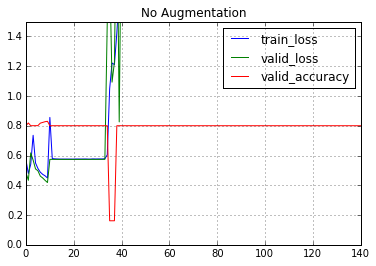

In [29]:
%matplotlib inline
import pandas as pd
dfAug = pd.DataFrame(netAug.train_history_)
dfAug[['train_loss','valid_loss','valid_accuracy']].plot(title='No Augmentation', ylim=(0,1.5))
#dfAug.to_csv("complex_network_no_aug.txt")
#dfAug.to_csv("~/Dropbox/Server_Sync/complex_network_no_aug.txt")

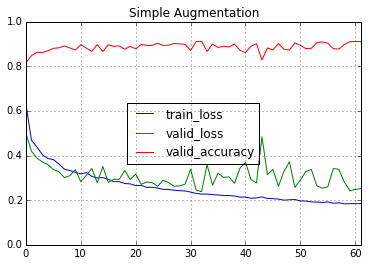

In [40]:
%matplotlib inline
import pandas as pd
dfAug = pd.DataFrame(net1Aug.train_history_)
dfAug[['train_loss','valid_loss','valid_accuracy']].plot(title='Simple Augmentation', ylim=(0,1))

In [27]:
dfAug

,dur,epoch,train_loss,train_loss_best,valid_accuracy,valid_loss,valid_loss_best
0,114.313053,1,0.715738,True,0.775564,0.559183,True
1,117.213370,2,0.549865,True,0.812658,0.517416,True
2,119.942494,3,0.498777,True,0.826795,0.453322,True
3,120.070604,4,0.459562,True,0.846452,0.417397,True
4,120.313769,5,0.427428,True,0.753747,0.590972,False
5,120.034848,6,0.415635,True,0.860209,0.409296,True
6,120.514310,7,0.382319,True,0.832315,0.444194,False
7,120.369509,8,0.379969,True,0.874711,0.351783,True
8,120.803190,9,0.346981,True,0.868518,0.367538,False
9,120.875407,10,0.332722,True,0.859976,0.392855,False


In [24]:
pred = netAug.predict(X_test)

In [94]:
sum(pred == Y_test)/float(len(Y_test))#0.8986779981114259, 0.9244570349386213, 0.93512747875354107, 0.94135977337110477 (146 Epochs)

0.90936863543788182

In [26]:
import cPickle as pickle
if False:
    with open('net_PAPER_aug_epoch512_72x72large_net.pickle', 'wb') as f:
        pickle.dump(netAug, f, -1)

In [53]:
from sklearn.metrics import confusion_matrix
import pandas as pd
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
#m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
1.0*np.sum(m[np.diag_indices(4)]) / np.sum(m)

NameError: name 'm' is not defined

In [14]:
m = [[7775,13,208,0],[28,382,23,1],[414,8,1657,0],[0,0,0,81]]
m = np.asmatrix(m)
np.sum(m), np.shape(m)
(m.sum(axis=0)[np.newaxis,:])[0]

matrix([[8217,  403, 1888,   82]])

### Normalizing the confusion matrix
See http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [93]:
#cm_normalized = m.astype('float') / ((m.sum(axis=1)[:, np.newaxis]))
#cm_normalized = m / ((m.sum(axis=0)[np.newaxis,:]))
cm_normalized = m.astype('float') / ((m.sum(axis=0)[np.newaxis,:])[0])
print('Normalized confusion matrix')
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
#m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(cm_normalized)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df


NameError: name 'm' is not defined

In [95]:
np.mean(cm_normalized[np.diag_indices(4)])

NameError: name 'cm_normalized' is not defined

In [18]:
1 - np.mean(cm_normalized[np.diag_indices(4)])

0.060111729817178494